# Initialize environment

In [1]:
using Pkg
Pkg.activate("..")

using Printf, Statistics,
        JLD2, FileIO, Interpolations, PyCall, PyPlot, PyPlotPlus, DataStructures,
        SqueezeDispersion.Samoan

@pyimport matplotlib.colors as clrs

using LinearAlgebra: norm

usecmbright() # for plotting

function compileoverturns(vmp; davg=nothing)

    overturns = Dict{Symbol,Array{Float64,1}}()
       overturns[:z] = Array{Float64,1}()
     overturns[:sig] = Array{Float64,1}()
      overturns[:dz] = Array{Float64,1}()
    overturns[:dsig] = Array{Float64,1}()

    for name in keys(vmp)
        z, ep, sig = unpack_vmp_profile(vmp[name])
        
        if davg != nothing
            sig = movingavg(sig, davg)
        end
        
        z_ov, sig_ov, z_delta, sig_delta = getoverturns(z, sig)
        
        append!(overturns[:z], z_ov)
        append!(overturns[:sig], sig_ov)    
        append!(overturns[:dz], z_delta) 
        append!(overturns[:dsig], sig_delta)
    end
    
    overturns
end

toradians(x...) = (2π/180 * y for y in x)

┌ Info: Recompiling stale cache file /Users/gregorywagner/.julia/compiled/v1.0/SqueezeDispersion/TsKDn.ji for SqueezeDispersion [b60af848-b6c1-11e8-3789-85de93651b40]
└ @ Base loading.jl:1187


toradians (generic function with 1 method)

# Load data

In [5]:
datapath = joinpath("..", "data", "samoanpassagedata.jld2")
ctd = load(datapath, "ctd")
vmp = load(datapath, "vmp")

# Sort vmp data from south to north
vmpbylat = OrderedDict{Float64,Any}()
for (name, profile) in vmp
    profile["name"] = name
    vmpbylat[profile["lat"]] = profile
end

sort!(vmpbylat)
vmp = OrderedDict{String,Any}()
for profile in values(vmpbylat)
    vmp[profile["name"]] = profile
end

ctdlon = ctd["lon"]
ctdlat = ctd["lat"]
ctdsigma = ctd["sigma4"]
ctddepth = ctd["depth"]

nz, nctd = size(ctdsigma)
nvmp = length(vmp)
println("CTD data size: ndepth = $nz, nctd = $nctd, nvmp = $nvmp\n")

firstprofile = "SP1_Line9_02"
lat0 = vmp[firstprofile]["lat"]
lon0 = vmp[firstprofile]["lon"]
dist0 = 0.0

println("VMP profiles:\n")
for (i, profile) in enumerate(values(vmp))
    z, ep, sig = unpack_vmp_profile(profile)  
    
    lat = profile["lat"]
    lon = profile["lon"]
    
    lat1, lon1, lat2, lon2 = toradians(lat0, lon0, lat, lon)
    profile["distance"] = latlondist(lat1, lon1, lat2, lon2) + dist0
    
    @printf("% 13s (%.2f N, %.2f W) | x: % 7.2f km, z: (%d, %d) meters, σ₄: (%.5f, %.5f) kg/m³\n", 
        profile["name"], lat, lon, profile["distance"]*1e-3, z[1], z[end], 
        nanmaximum(sig), nanminimum(sig))
    
    dist0 = profile["distance"]
    lat0 = lat
    lon0 = lon
    
end

CTD data size: ndepth = 6001, nctd = 18, nvmp = 13

VMP profiles:

 SP1_Line9_02 (-9.83 N, -169.31 W) | x:    0.00 km, z: (-5303, -3442) meters, σ₄: (45.97834, 45.85083) kg/m³
 SP1_Line9_04 (-9.48 N, -169.02 W) | x:   98.06 km, z: (-5234, -3442) meters, σ₄: (45.97827, 45.85180) kg/m³
 SP1_Line9_06 (-9.14 N, -168.98 W) | x:  173.25 km, z: (-5122, -3442) meters, σ₄: (45.97770, 45.85166) kg/m³
 SP1_Line9_07 (-9.04 N, -168.96 W) | x:  195.81 km, z: (-4962, -3442) meters, σ₄: (45.97797, 45.85172) kg/m³
 SP1_Line9_08 (-8.99 N, -168.96 W) | x:  207.77 km, z: (-4691, -3442) meters, σ₄: (45.97777, 45.84898) kg/m³
 SP1_Line9_09 (-8.90 N, -168.90 W) | x:  231.41 km, z: (-4990, -3442) meters, σ₄: (45.97545, 45.84830) kg/m³
SP1_Line9_102 (-8.81 N, -168.76 W) | x:  266.09 km, z: (-4977, -3442) meters, σ₄: (45.97648, 45.84982) kg/m³
SP1_Line9_112 (-8.61 N, -168.73 W) | x:  309.32 km, z: (-5079, -3442) meters, σ₄: (45.97665, 45.85238) kg/m³
 SP1_Line9_13 (-8.31 N, -168.66 W) | x:  377.52 km, z: (-5052

# Visualize data

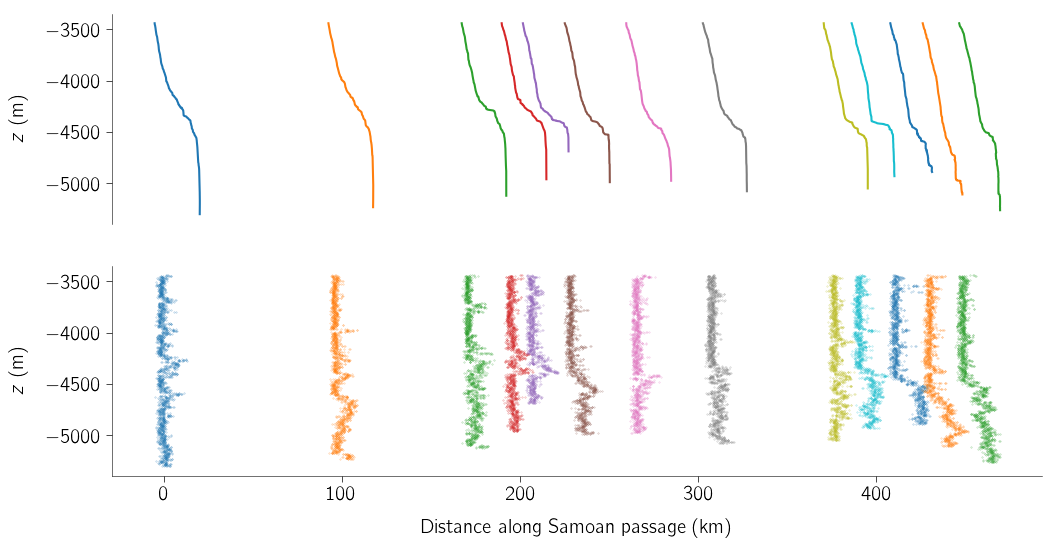

In [9]:
fig, axs = subplots(nrows=2, figsize=(12, 6))

sca(axs[1])
sidespine()
axs[1][:tick_params](bottom=false, labelbottom=false)
ylabel(L"z \, \, \mathrm{(m)}", labelpad=12.0)

sca(axs[2])
cornerspines()
xlabel("Distance along Samoan passage (km)"; labelpad=12.0)
ylabel(L"z \, \, \mathrm{(m)}", labelpad=12.0)

m_ep = 5e3 # [ep]/[distance]
m_sig = 2e8

for (i, profile) in enumerate(values(vmp))
    z, ep, sig = unpack_vmp_profile(profile)
    
    ep_filtered = filter(x->x>0 && isfinite(x), ep)
    offset_ep = nanmean(log.(10, ep_filtered))
    offset_sig = nanminimum(sig)
    gtz = ep .> 0
     
    # Visualize density profile and dissipation along the track.
    sca(axs[1])
    plot(1e-3*(m_sig.*(sig.-offset_sig)) .+ profile["distance"], z, "-")
    
    sca(axs[2])
    plot(1e-3*(m_ep.*(log.(10, ep[gtz]).-offset_ep) .+ profile["distance"]), z[gtz], ".", linewidth=1, markersize=0.5, alpha=0.6)
    
end

# Analyze overturns

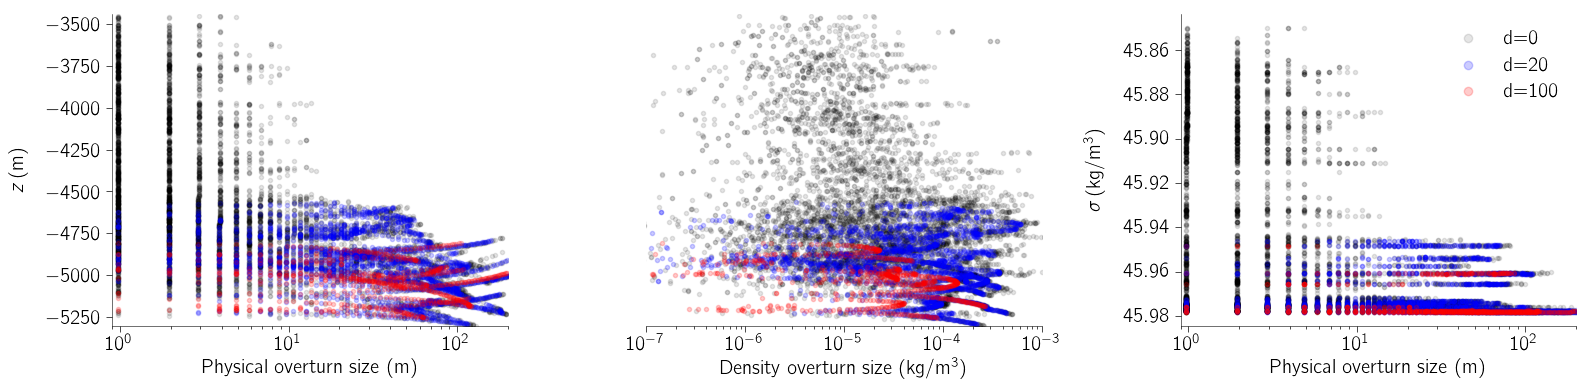

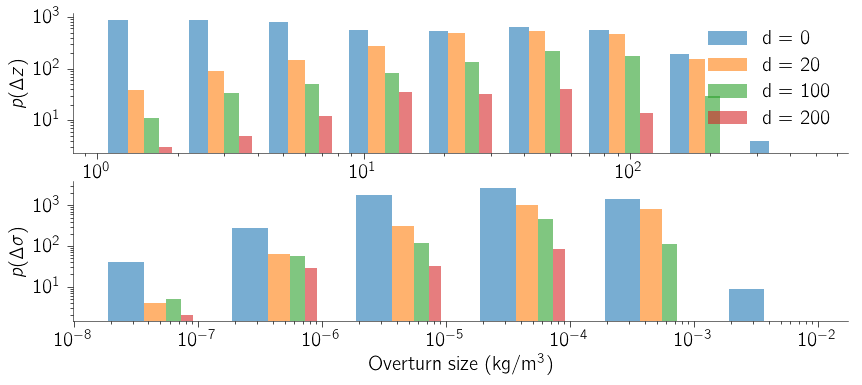

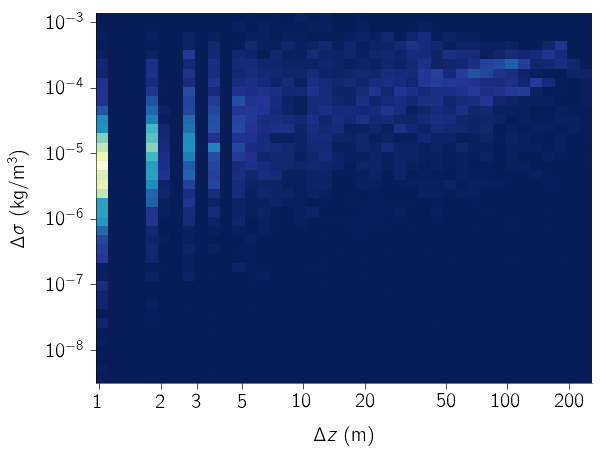

In [25]:
zlims = (-5305, -3442)
zdeltalims = (0.9, 200)
sigdeltalims = (1e-7, 1e-3)

overturns0 = compileoverturns(vmp)
overturns1 = compileoverturns(vmp, davg=20)
overturns2 = compileoverturns(vmp, davg=100)

fig, axs = subplots(ncols=3, figsize=(16, 4))
    
sca(axs[1])
xlabel("Physical overturn size (m)")
ylabel(L"z \, \mathrm{(m)}", labelpad=12.0)

cornerspines()
xscale("log")
xlim(zdeltalims)
ylim(zlims)

plot(overturns0[:dz], overturns0[:z], "k.", alpha=0.1)
plot(overturns1[:dz], overturns1[:z], "b.", alpha=0.2)
plot(overturns2[:dz], overturns2[:z], "r.", alpha=0.2)

sca(axs[2])
xlabel("Density overturn size \$ \\mathrm{(kg/m^3)} \$")
bottomspine()
xscale("log")
axs[2][:tick_params](left=false, labelleft=false)
xlim(sigdeltalims)
ylim(zlims)

plot(overturns0[:dsig], overturns0[:z], "k.", alpha=0.1)
plot(overturns1[:dsig], overturns1[:z], "b.", alpha=0.2)
plot(overturns2[:dsig], overturns2[:z], "r.", alpha=0.2)


sca(axs[3])
xlabel("Physical overturn size (m)")
ylabel(L"\sigma \, \mathrm{(kg/m^3)}", labelpad=12.0)
cornerspines()
xscale("log")
xlim(zdeltalims)
#ylim(zlims)
invertaxis()

plot(overturns0[:dz], overturns0[:sig], "k.", alpha=0.1, label="d=0")
plot(overturns1[:dz], overturns1[:sig], "b.", alpha=0.2, label="d=20")
plot(overturns2[:dz], overturns2[:sig], "r.", alpha=0.2, label="d=100")

legend()
tightshow()

# Create an array of overturn dictionaries.
overturns = [compileoverturns(vmp)]
davgs = [20, 100, 200]

for d in davgs
    append!(overturns, [compileoverturns(vmp, davg=d)])
end

davgs = cat([0], davgs, dims=1)

# Plot
fig, axs = subplots(nrows=2, figsize=(10, 4))

sca(axs[1])
xlabel("Overturn size (m)")
ylabel(L"p(\Delta z)")
cornerspines()
xscale("log")
yscale("log")

bins = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
axs[1][:hist](map(x->x[:dz], overturns), bins, alpha=0.6, label=map(x-> "d = $x", davgs))
legend()

sca(axs[2])
xlabel("Overturn size (kg/m\$^3\$)")
ylabel(L"p(\Delta \sigma)")
cornerspines()
xscale("log")
yscale("log")

#bins = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
bins = 10.0 .^ (-8:-2)
axs[2][:hist](map(x->x[:dsig], overturns), bins, alpha=0.6, label=map(x-> "d = $x", davgs))
#legend()

# 2D histogram
dzs = [1, 2, 3, 5, 10, 20, 50, 100, 200]
dsigs = 10.0 .^ (-8:-3)

fig2, ax2 = subplots()
xlabel(L"\Delta z \,\, \mathrm{(m)}"; labelpad=12.0)
ylabel(L"\Delta \sigma \,\, \mathrm{(kg/m^3)}"; labelpad=12.0)

xticks(log.(10, dzs), map(x->"$x", dzs))
yticks(log.(10, dsigs), map(x->@sprintf("\$10^{%d}\$", log(10, x)), dsigs))

cornerspines()

ax2[:hist2d](log.(10, overturns0[:dz]), log.(10, overturns0[:dsig]), bins=40);

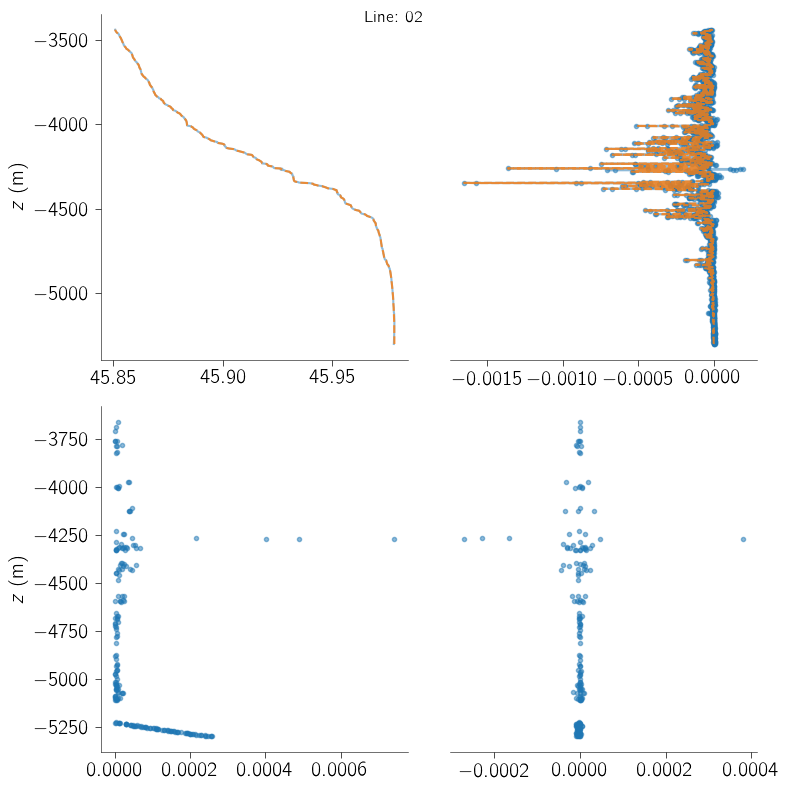

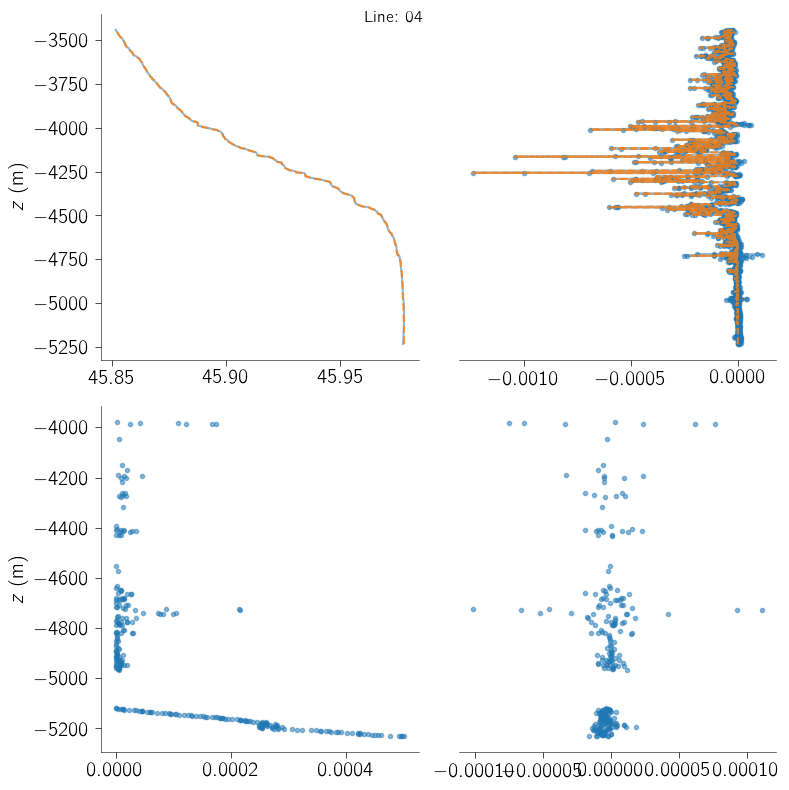

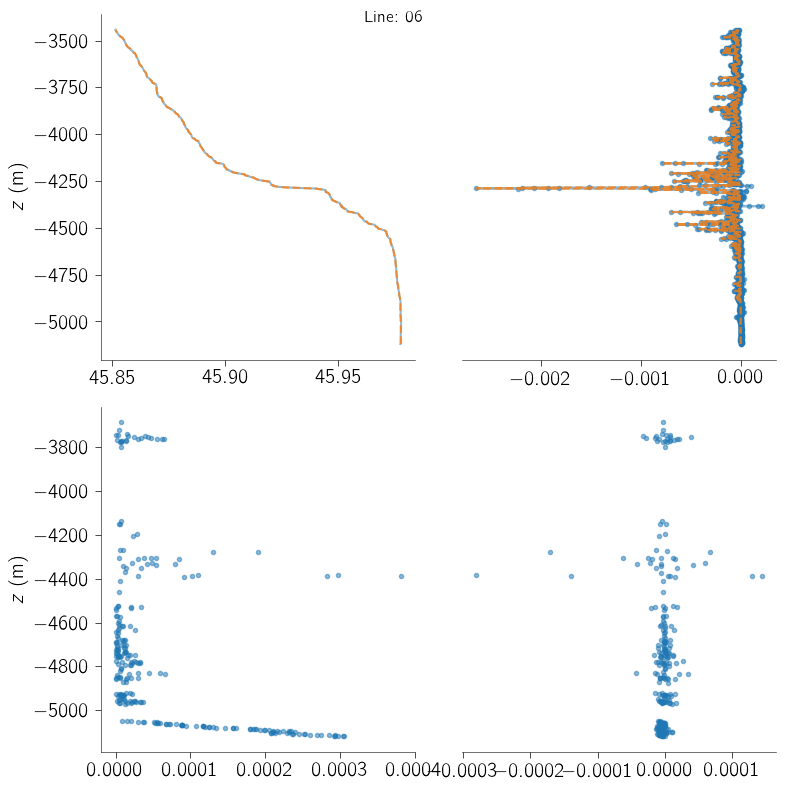

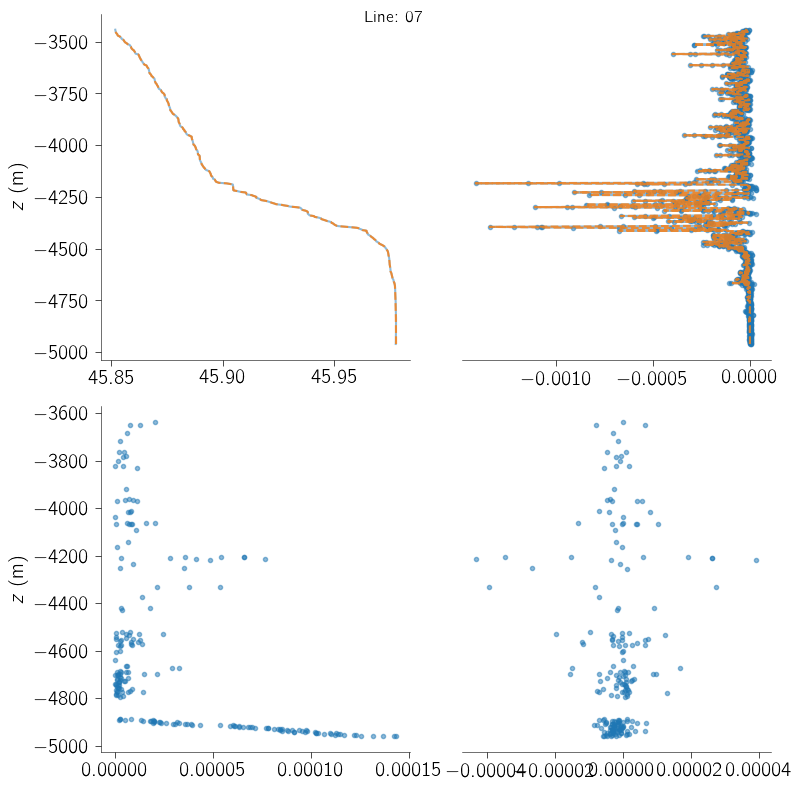

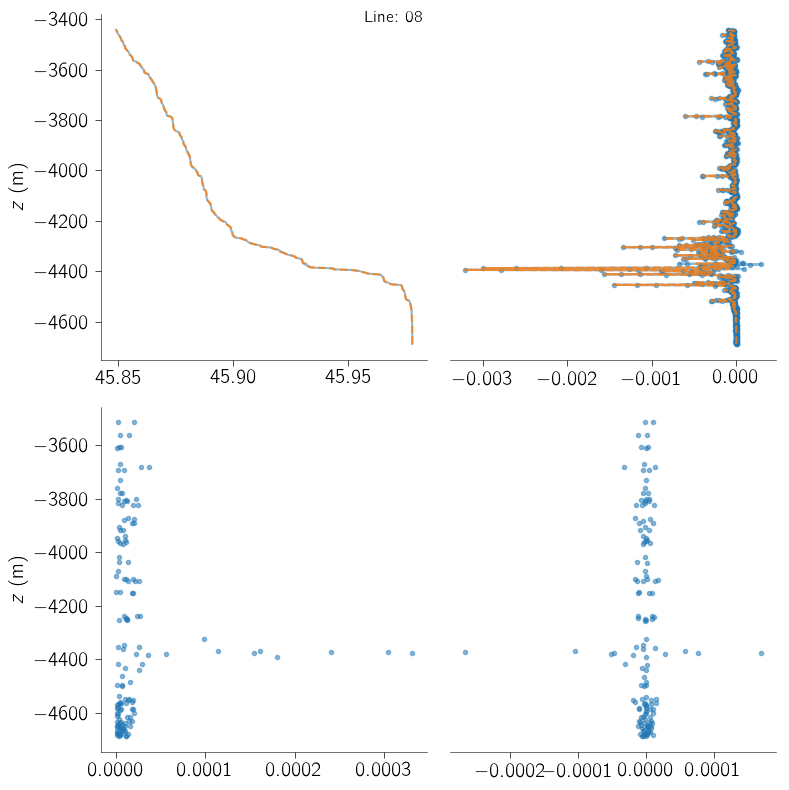

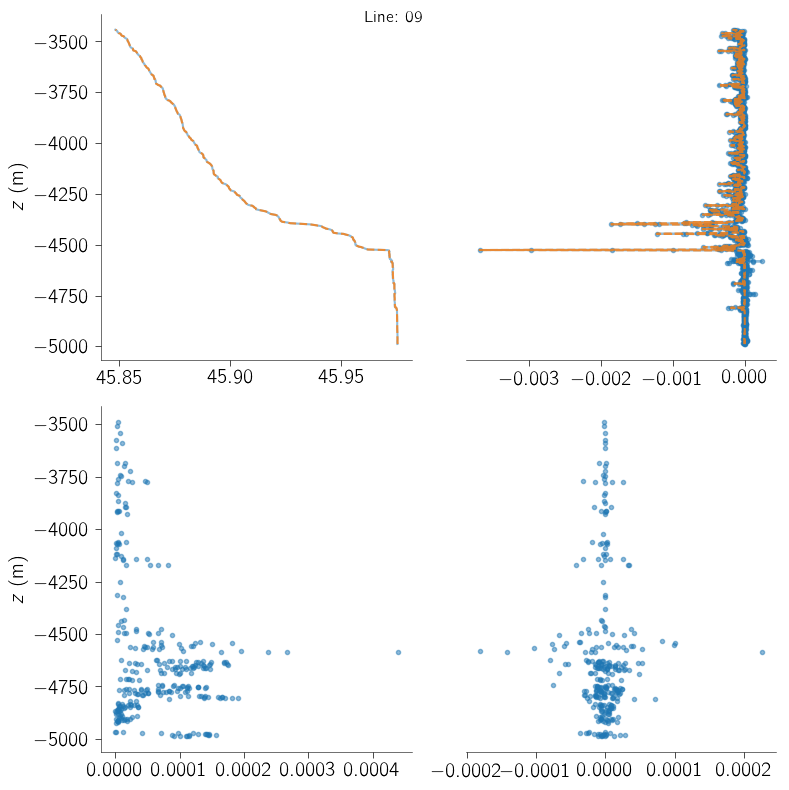

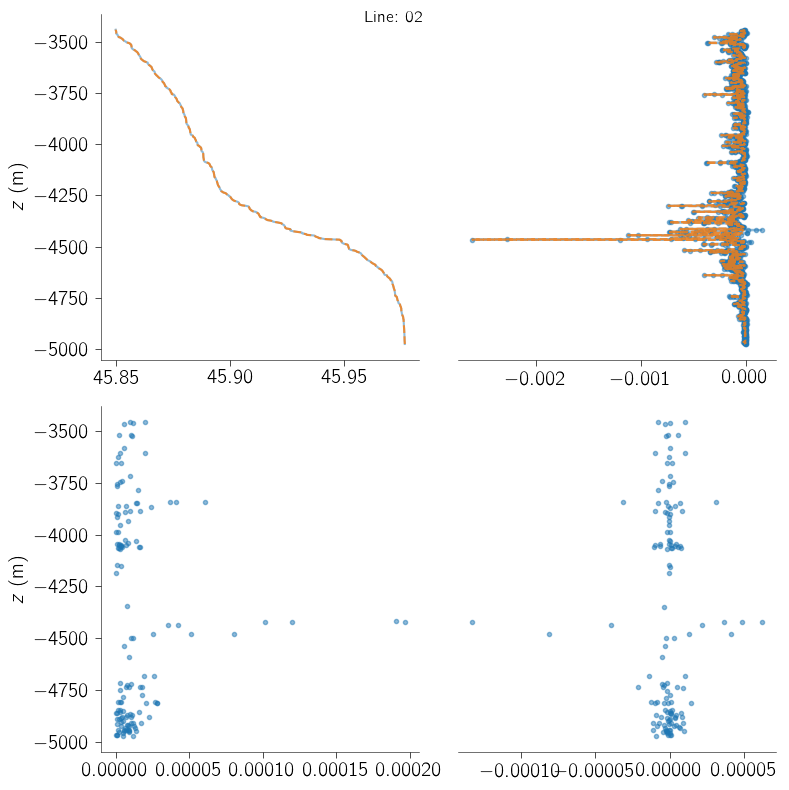

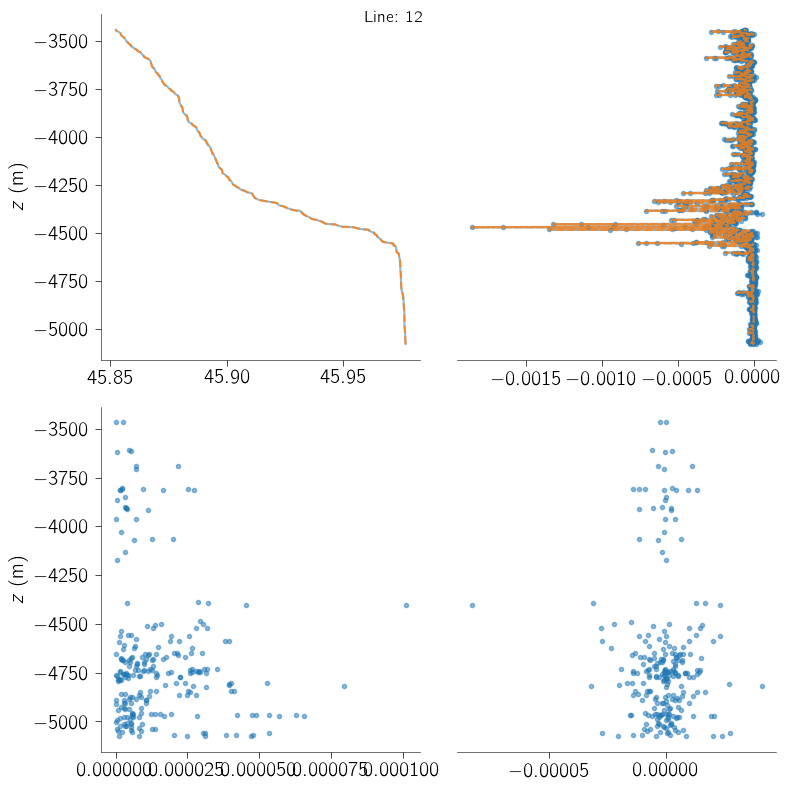

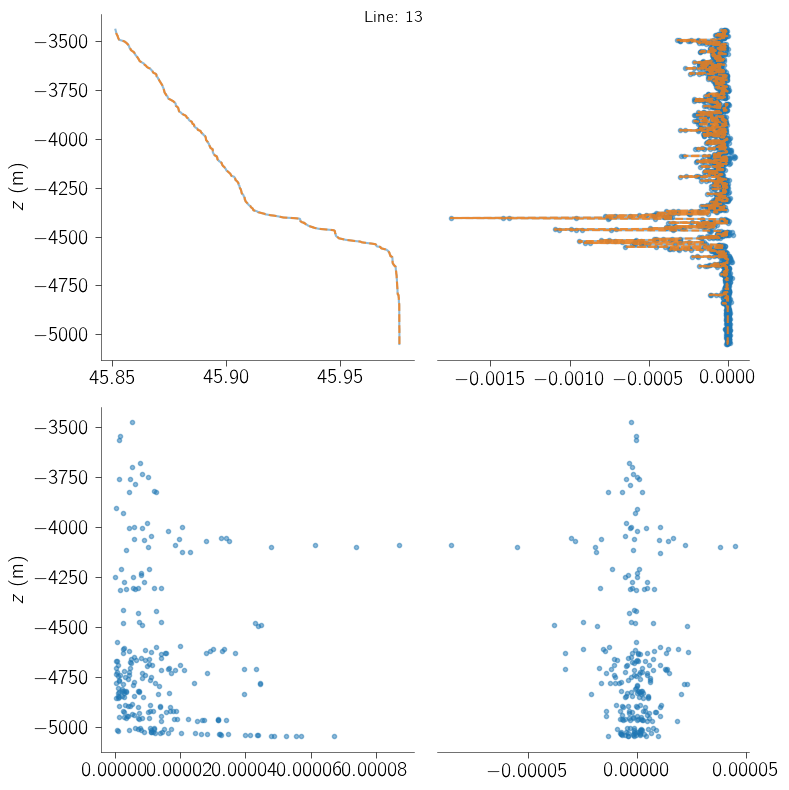

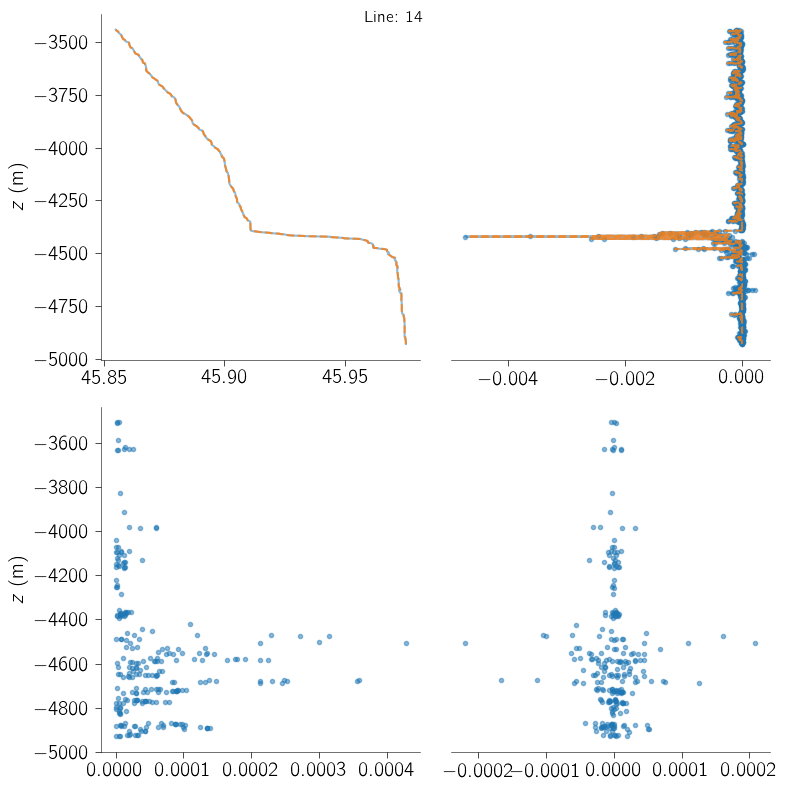

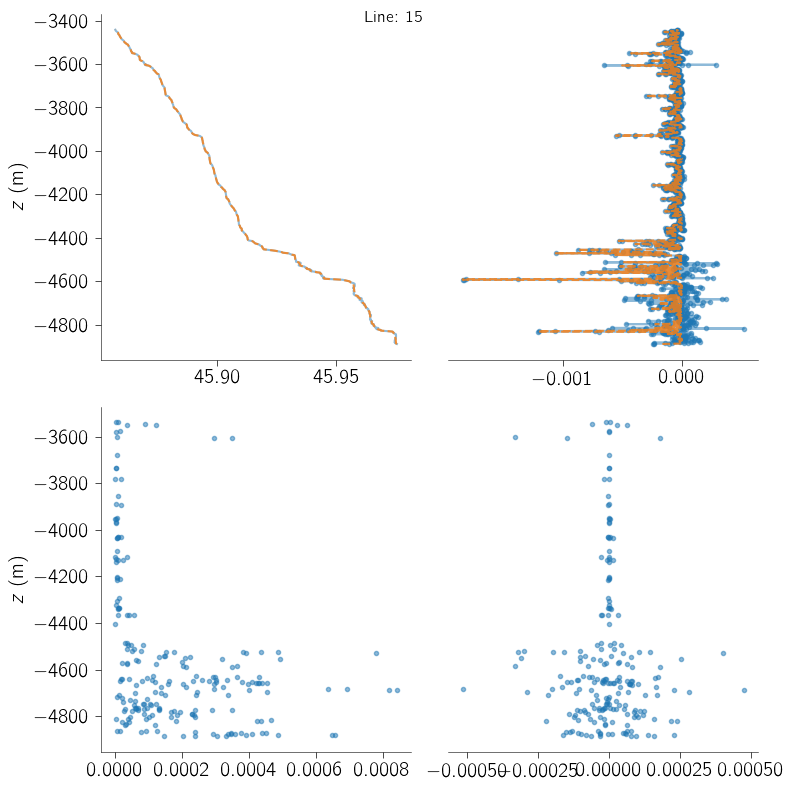

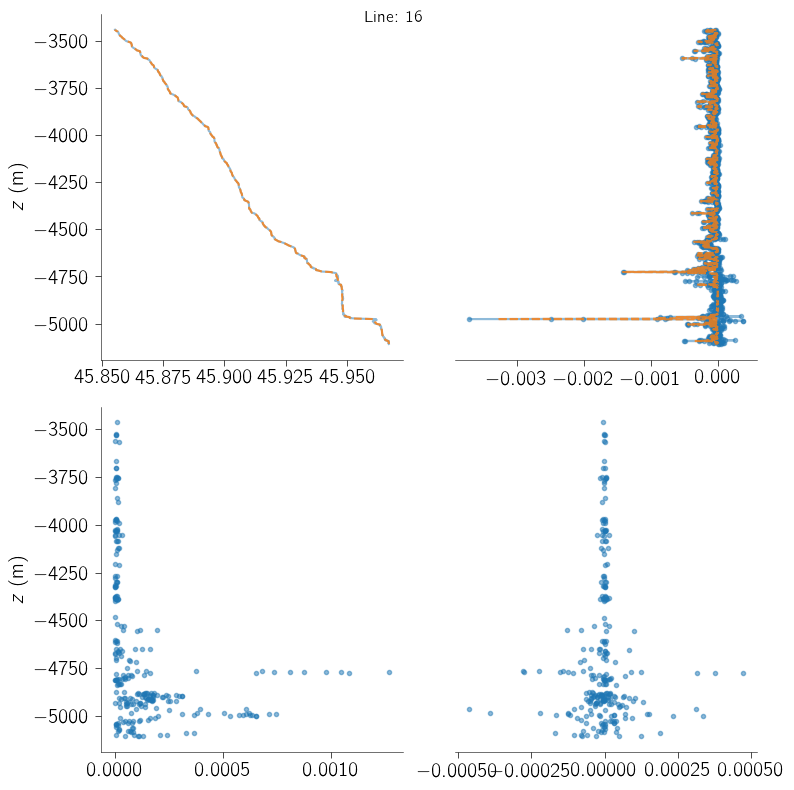

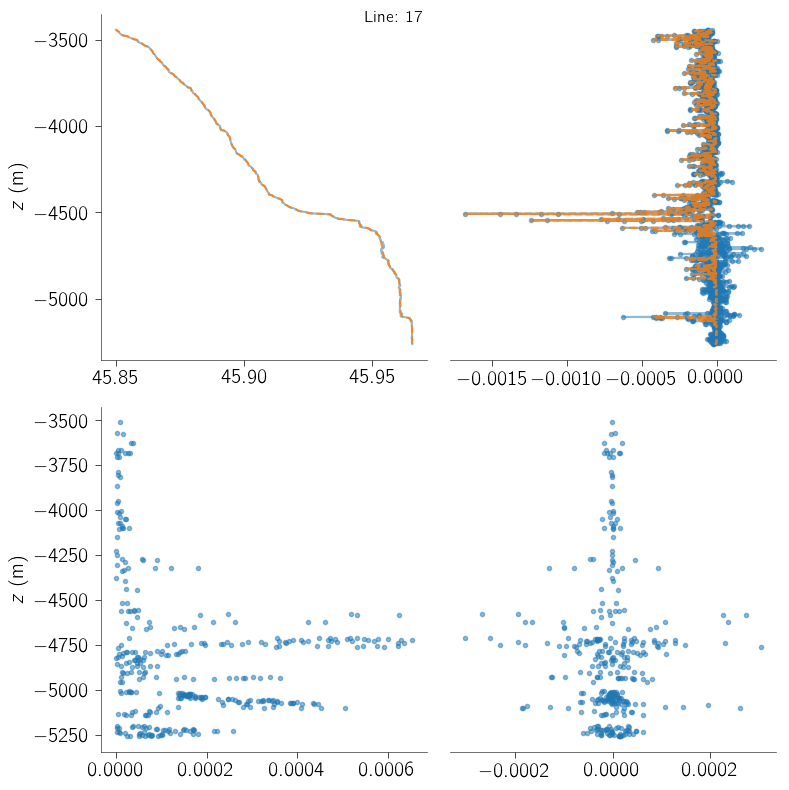

In [164]:


for (i, name) in enumerate(keys(vmp))

    #name = "SP1_Line9_04"

    fig, axs = subplots(ncols=2, nrows=2, figsize=(8, 8))
    fig[:suptitle]("Line: $(name[end-1:end])")

    z, ep, sig = unpack_vmp_profile(vmp[name])

    sig_sorted = sort(sig, rev=true)
    dsig = sig_sorted .- sig
    nonzero = dsig .> 0

    sig_z = dz(sig, z)
    sig_sorted_z = dz(sig_sorted, z)
    dsigz = sig_sorted_z .- sig_z

    sca(axs[1, 1])
    ylabel(L"z \, \, \mathrm{(m)}")
    cornerspines()

    plot(sig, z, "-", alpha=0.5)
    plot(sig_sorted, z, "--", alpha=0.8)

    sca(axs[1, 2])
    bottomspine()
    axs[1, 2][:tick_params](left=false, labelleft=false)

    plot(sig_z, z, linestyle="-", marker=".", alpha=0.5)
    plot(sig_sorted_z, z, "--", alpha=0.8)

    sca(axs[2, 1])
    ylabel(L"z \, \, \mathrm{(m)}")
    cornerspines()

    plot(dsig[nonzero], z[nonzero], ".", alpha=0.5)

    sca(axs[2, 2])
    bottomspine()
    axs[2, 2][:tick_params](left=false, labelleft=false)

    plot(dsigz[nonzero], z[nonzero], ".", alpha=0.5)

    tightshow()
    
end